# Consegna
Lo scopo di questo progetto è duplice. Per ogni campione

1. Fare una clusterizzazione degli spettri e verificare se questa correla con la posizione geometrica dei punti di rilievo
2. Costruire un classificatore per il tipo di materiale

Per il punto 2, verranno forniti dei label per ogni spettro più avanti. In prima istanza, si può procedere assegnando i label agli spettri sulla base della somiglianza con gli spettri di campioni puri contenuti nella cartella `Database Raman`.

È richiesta inoltre una EDA degli spettri. Considerare:
1. range in cui si trovano i picchi
2. numero di picchi (se riuscite a misurarlo in modo automatico, e.g. basandosi sulle derivate, facoltativo)
3. intensità (integrale) degli spettri
4. ...


## Dati forniti
Vengono forniti, inizialmente, i seguenti dati (altri sono disponibili su richiesta).

* Due campioni con e senza background noise rimosso
* Una cartella `Database Raman` con gli spettri di riferimento (senza background) per diversi materiali puri.

I file contenuti nella cartella `Database Raman` sono nominati a seconda del materiale e contengono ciascuno due colonne. La prima è il numero d'onda (unità 1/cm), cioè l'inverso della lunghezza d'onda. La seconda contiene l'intensità dello scattering raman misurato a quel numero d'onda.

I file campione contengono gli spettri raccolti lungo una griglia di 11 righe x 11 colonne. Ogni punto dista dagli altri un micron. Ognuno di questi file contiene 122 colonne. La prima raccoglie i numeri d'onda, sempre in unità 1/cm, le restanti 121 gli spettri, ordinati come segue: le prime 11 colonne corrispondono alla prima riga di punti sul campione, le seconde 11 alla riga sottostante, e così via. 

Sono forniti due campioni, denominati `S1` e `S2`. Per ognuno di questi sono forniti due files: `_mapA` e `_bkg_mapA`. Nel secondo è stato rimosso il rumore di fondo (background), permettendo di confrontare più facilmente lo spettro con gli spettri di riferimento nella cartella `Database Raman`. 

Gli spettri **non sono normalizzati**. L'integrale delle curve corrisponde sperimentalmente all'esposizione e quindi al tempo di raccolta del segnale. Gli spettri a background rimosso e quelli nella cartella `Database Raman` si possono normalizzare al fine di compararli. 

Le finestre di acquisizione per gli spettri di riferimento e quelli raccolti sono diverse, ma le unità sono simili.

Il file `RRUF_list.txt` contiene una lista di spettri.

### Suggerimenti
Per provare a dare un label ai vari spettri, definite una distanza tra due spettri.

Potrebbe essere necessario fare una piccola interpolazione per paragonare gli spettri di riferimento a quelli misurati. 

# Buttiamo giù delle idee
Tentiamo in questo notebook di capire il più possibile dai dati, comprendere come sono strutturati, come pulirli per prepararli ai fit.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
#import seaborn as sns
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
%matplotlib inline


## Importazione degli spettri del sample e quelli puri

In questa sezione importiamo i dati, sia quelli dei sample di materiale incognito che gli spettri relativi ai materiali puri.

In [2]:
#definisco i nomi delle colonne
names = ['wn']+[f'r{k}c{i}' for k in range(1,12) for i in range(1,12)] #wn -> wave number  r -> row c -> column

In [6]:
#quì importiamo i dati dei sempling in dataframes pandas, la colonna dei numeri d'onda è una unica per tutti
data_S1 = pd.read_csv('../data/raw/S1_mapA_11x11.txt', delim_whitespace=True, names=names)
data_S1bkg = pd.read_csv('../data/raw/S1_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)
data_S2 = pd.read_csv('../data/raw/S2_mapA_11x11.txt', delim_whitespace=True, names=names)
data_S2bkg = pd.read_csv('../data/raw/S2_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)

In [7]:
# gli spettri Raman dei materiali puri hanno ognuno uno wn diverso, generiamo dunque un dataframe vuoto delle
# dimensioni corrette, e poi aggiungiamo 2 colonne per spettro con wn e l'intensità (probabilmente c'è un 
# metodo migliore)

# definisco i nomi dei vari materiali usando il file che li contiene tutti
pure_material_names=[]
with open('../data/raw/Database Raman/BANK_LIST.dat') as f:
    pure_material_names=[i[1:len(i)-5] for i in f.readlines()]
l=[]
for i in range(len(pure_material_names)):
    l.append(pd.read_csv('../data/raw/Database Raman/'+pure_material_names[i]+'.txt', delim_whitespace=True, names=[pure_material_names[i]+'_wl',pure_material_names[i]+'_I']).size)
max_size=int(max(l)/2)

In [9]:
# genero un dataframe vuoto per poter usare il metodo join
pure_materials = pd.DataFrame(np.zeros(max_size),columns=['empty'])
# importiamo i dati: nome_I (intensità) e nome_wn
for i in range(len(pure_material_names)):
    pure_materials=pure_materials.join(pd.read_csv('../data/raw/Database Raman/'+pure_material_names[i]+'.txt', delim_whitespace=True, names=[pure_material_names[i]+'_wn',pure_material_names[i]+'_I']))
    
pure_materials.drop('empty', axis = 1,inplace=True)

## Vediamo rapidamente cosa contengono gli spettri di sempling

Qui sotto sono riportati alcuni spettri, con il background, per far vedere come si comportano. 

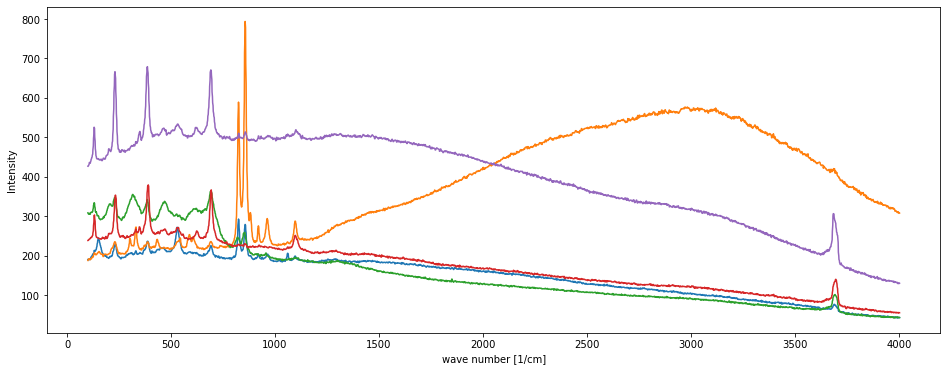

In [10]:
def raman_plot():
    plt.figure(figsize=(16,6))
    plt.xlabel("wave number [1/cm]")
    plt.ylabel("Intensity")
    
raman_plot()
plt.plot(data_S1.wn,data_S1.r1c1)
plt.plot(data_S1.wn,data_S1.r1c2)
plt.plot(data_S1.wn,data_S1.r1c3)
plt.plot(data_S1.wn,data_S1.r1c4)
plt.plot(data_S1.wn,data_S1.r1c5)

E quì li plotto tutti in sieme

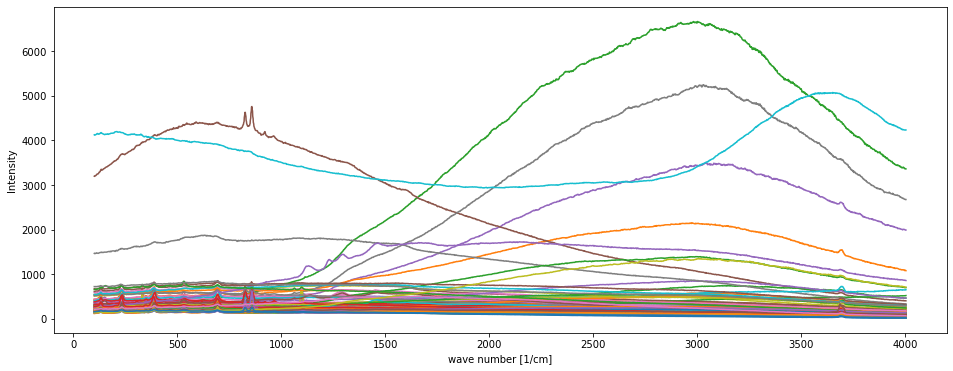

In [11]:
raman_plot()
for temp in names[1:]:
    plt.plot(data_S1.wn,data_S1[temp])

Gli stessi spettri a background rimosso.

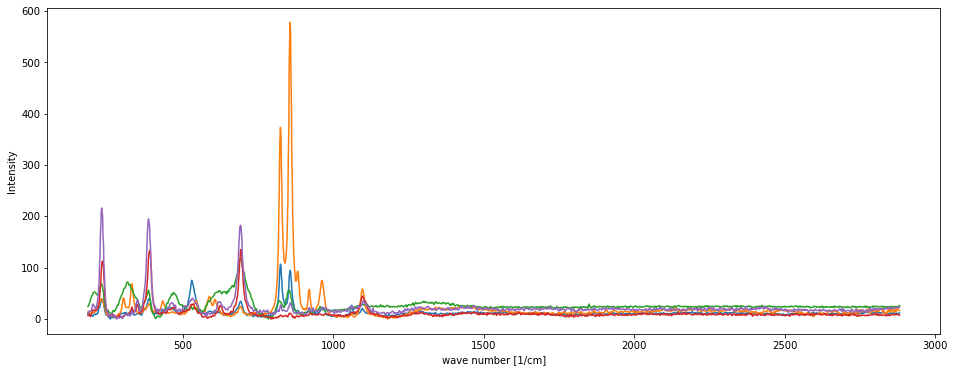

In [12]:
raman_plot()
plt.plot(data_S1bkg.wn,data_S1bkg.r1c1)
plt.plot(data_S1bkg.wn,data_S1bkg.r1c2)
plt.plot(data_S1bkg.wn,data_S1bkg.r1c3)
plt.plot(data_S1bkg.wn,data_S1bkg.r1c4)
plt.plot(data_S1bkg.wn,data_S1bkg.r1c5)

E quì li plotto tutti in sieme, notiamo che quelli più brutti senza beckground corrispondono a quelli più brutti anche con. Alcuni spettri non hanno sicuramente significato fisico, dovremmo vederli come trattarli e identificarli.

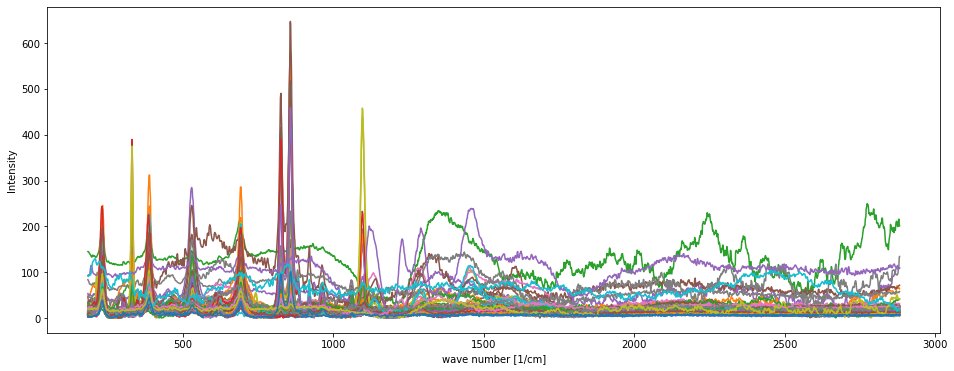

In [13]:
raman_plot()
for temp in names[1:]:
    plt.plot(data_S1bkg.wn,data_S1bkg[temp])

Vediamo la differenza tra spettro con beckground e senza (I file con e senza background hanno frequenze diverse)

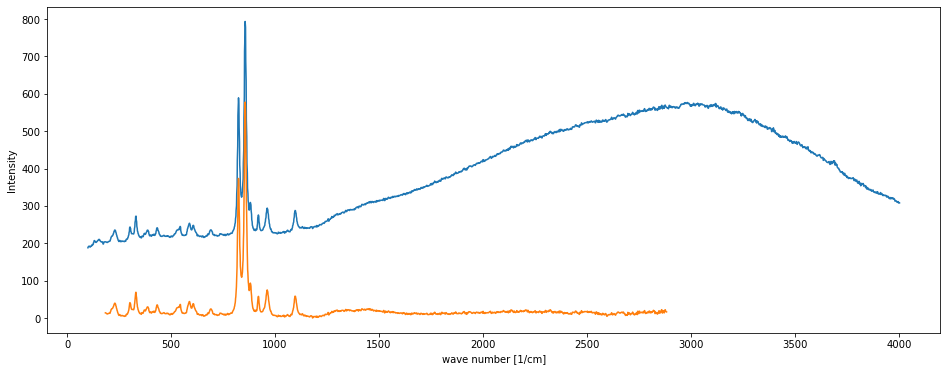

In [14]:
raman_plot()
plt.plot(data_S1.wn,data_S1.r1c2)
plt.plot(data_S1bkg.wn,data_S1bkg.r1c2)

**Cerchiamo ora di capirne un po' di più buttando giù delle idee o ipotesi: come diminuire il rumore, come eliminare eventuali offsets, come trattare spettri che apparentemente non hanno significato ecc...**

## Cerchiamo di capire dagli spettri puri cosa ci aspettiamo da uno spettro Raman

Vediamo uno spettro tipico del Database di riferimento. Notare come sia meno rumoroso, nonché la scala in x molto più ridotta.

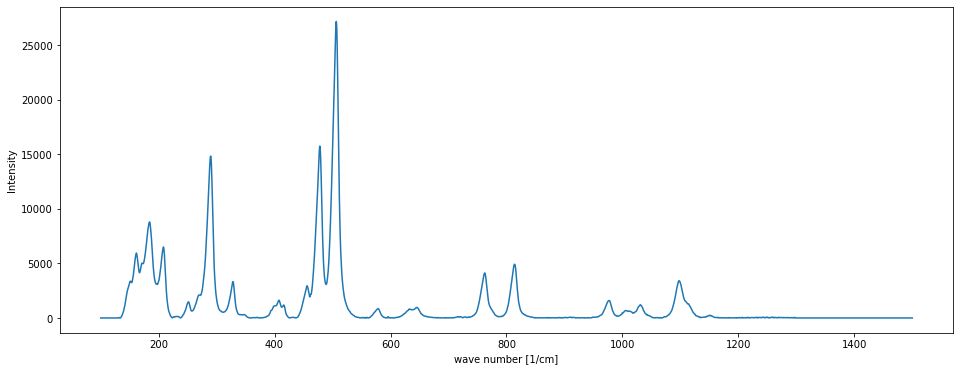

In [15]:
raman_plot()
plt.plot(pure_materials.Albite_wn,pure_materials.Albite_I)

Lo spettro è veramente bello, vediamoli tutti:

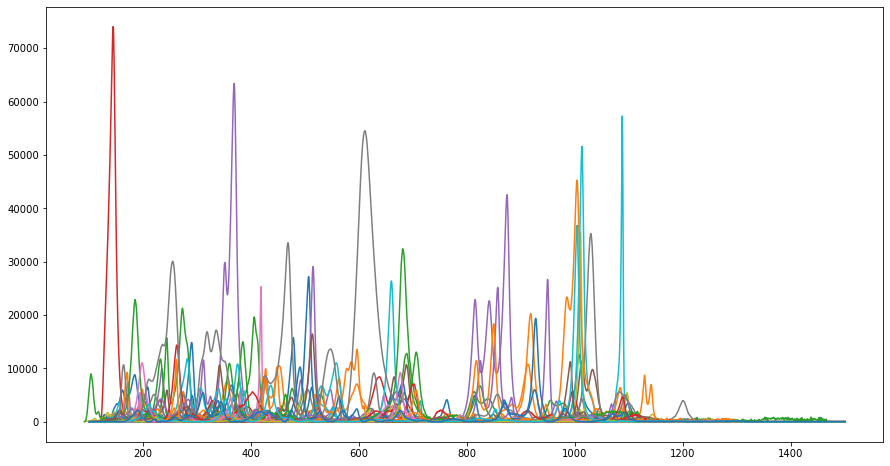

In [16]:
plt.figure(figsize=(15,8))
for i in range(len(pure_material_names)):
    plt.plot(pure_materials[pure_material_names[i]+'_wn'],pure_materials[pure_material_names[i]+'_I'])

Da questi spettri, molto meno rumorosi di quelli del sample, capiamo diverse cose:
1. **Per numeri d'onda superiori a 1250 $cm^{-1}$ tutti gli spettri Raman non presentano picchi, l'intensità a piccole lunghezze d'onda è nulla!**
2. **Gli spettri Raman, relativamente alle altezze dei picchi, non presentano un offset rilevante**
3. **Le FWHM dei picchi sono, certe volte, importanti: fino a 100 $cm^{-1}$.**
4. **Lo spettro fino a circa (dopo troviamo meglio questo punto) 1250 $cm^{-1}$ è densamente popolato.**

## Normalizzo li spettri puri

In [17]:
for i in pure_material_names:
    pure_materials[i+'_I']=pure_materials[i+'_I']/np.trapz(abs(pure_materials[i+'_I'].dropna()), x=pure_materials[i+'_wn'].dropna())

## Tentativo di rimuovere un po' di rumore dagli spettri binnando i numeri d'onda (credo fallito)

Prendo uno spettro e provo a toglierli il rumore (almeno un pochino) raggruppando il sempling. Devo stare attento a non esagerare altrimenti abbasso i picchi. Provo con un campine a caso.

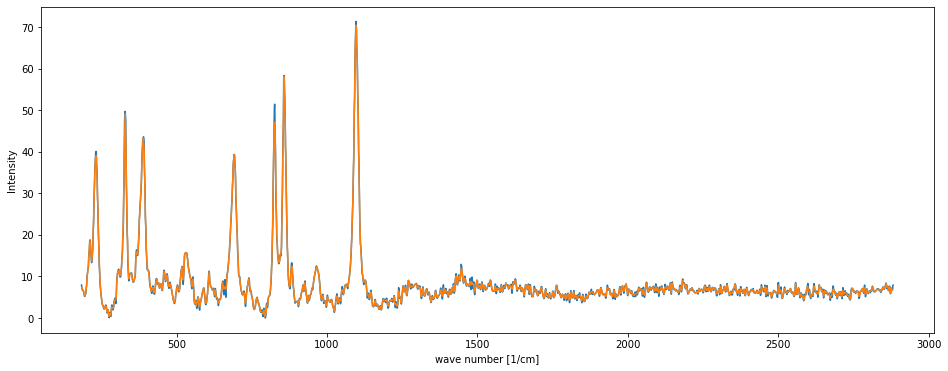

In [18]:
sample='r7c7' #scelgo su cosa guardare sta roba
N=3 #numero di raggruppamenti
x=[]
y=[]
for i in range(int(len(data_S1bkg[sample])/N)):
    y.append(data_S1bkg[sample][N*i:N*i+N].mean())   
for i in range(int(len(data_S1bkg.wn)/N)):
    x.append(data_S1bkg.wn[N*i:N*i+N].mean())   



raman_plot()
plt.plot(data_S1bkg.wn,data_S1bkg[sample])
plt.plot(x,y)


Risultato pessimo, rumore poco attenuato (stà a frequenze troppo basse) mentre i picchi sono modificati sensibilmente.
**Al limite potrebbe essere utile se lo facciamo con N=2 o 3, per ridurre un po il numero di dati. In questo caso la differenza non è importante.**

## Tentativo di sottrarre l'offset 

Prima faccio un fit alla parte destra del grafico....

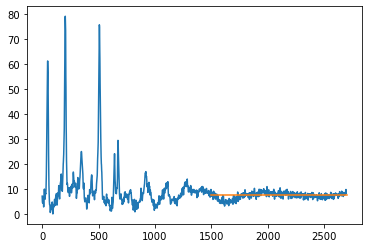

In [19]:
sample='r4c7' #il sample su cui faccio gli esempi
data_S1bkg[sample].plot()
offset=data_S1bkg[sample][1300::].mean()
sigma=data_S1bkg[sample][1300::].std() #calcolo la std che mi serve dopo

plt.plot([1500,2700],[offset,offset])

## Dato che rimuovere l'offset sebra un'ottima idea lo facio a tutti

In [20]:
wn_soglia=1300
for temp in names[1::]:
    offset=data_S1bkg[temp][wn_soglia::].mean()
    data_S1bkg[temp]=data_S1bkg[temp]-offset

## Tentativo di mettere una soglia al rumore

Una volta trovato l'offset metto a 0 e cancello il rumore sotto una soglia. Potrebbe essere interessante dare questa soglia in funzione della varianza della coda dello spettro.

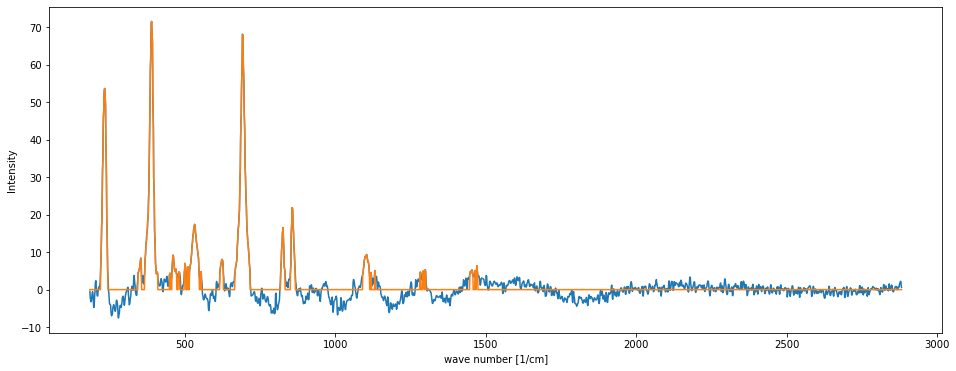

In [21]:
bound=3*sigma #fisso il bound del rumore a 4 volte il sigma della coda
y=data_S1bkg[sample].copy()
for i in enumerate(y):
    if i[1]<bound:
        y[i[0]]=0
x=data_S1bkg.wn        
raman_plot()
plt.plot(data_S1bkg.wn,data_S1bkg[sample])    
plt.plot(x,y)        

**Se volessi attuare questa tecnica a tutti gli spettri dovrei runnare la prossima cella**

In [22]:
%%HTML
vwn_soglia=1300
for temp in names[1::]:
    for i in enumerate(data_S1bkg[temp]):
        if i[1]<bound:
            data_S1bkg[temp][i[0]]=0

## Poi togliamo la coda che non ci serve più

Lo faremo direttamente a tutti gli spettri Raman

# Tentativo di identificare gli spettri Raman senza significato
Provo a utilizzare la varianza della coda degli spettri come bound,

In [23]:
sigma=[data_S1bkg[sample][1300::].std() for sample in names[1::]]
limit=10
#copio il dataframe dei sample esistente in altri due
bad_names=[]
good_names=[]
for i in enumerate(names[1::]):
    if sigma[i[0]]<limit:
        good_names.append(i[1])
    else:
        bad_names.append(i[1])

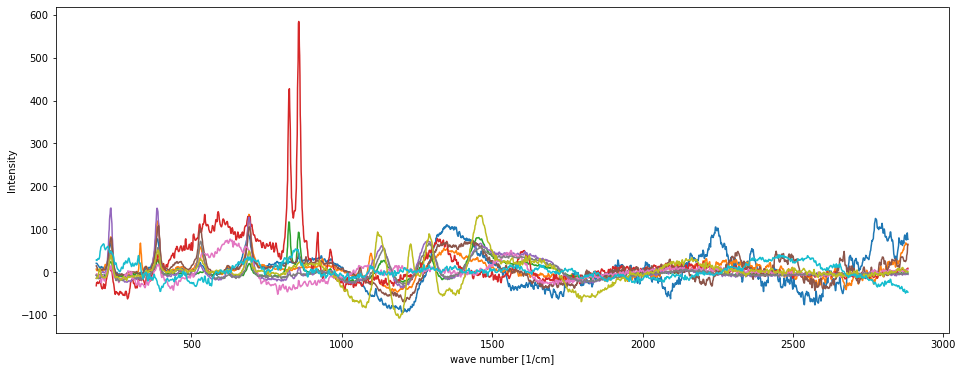

In [24]:
raman_plot()
for temp in bad_names[1:]:
    plt.plot(data_S1bkg.wn,data_S1bkg[temp])

## Trattiamo la normalizzazione

**Usando l'integrazione numerica, notiamo come le curve non siano normalizzate.**
è sicuramente tutto da normalizzare.

In [25]:
for i in names[1::]:
    data_S1bkg[i]=data_S1bkg[i]/np.trapz(abs(data_S1bkg[i]), x=data_S1bkg.wn)

## Alla fine della consegna tubiana scrive di definire una distanza tra gli spettri per potere classificarli",
   **Dato che siamo interessati a trovare i materiali principali che costituiscono uno spettro potremmo pesare di più le intensità più alte???**
   